In [1]:
import os
import re
from ast import literal_eval
import numpy as np
from scipy.ndimage import gaussian_filter1d, convolve1d
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns

from sxfst.utils import plotTraces, plot_set, proc, parse, Screen, PlateData, Cpd

dataDir = 'platereader'
paths = sorted([os.path.join(dataDir, i) for i in os.listdir(dataDir)])
test_paths = list(filter(lambda s : '16032022' in s, paths))
ctrl_paths = list(filter(lambda s : '12032022' in s, paths))

p0 = PlateData(test_paths[0])
p0

platereader/16032022,104721.CSV
User: USER,Path: C:\Program Files (x86)\BMG\CLARIOstar\User\Data\,Test run no.: 2828

 1  2  3  4  5  6  7  8  9  10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
A :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  : 
B :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  : 
C :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  : 
D :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  : 
E :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  : 
F :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  : 
G :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  : 
H :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  : 
I :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  : 
J :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  : 
K :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :

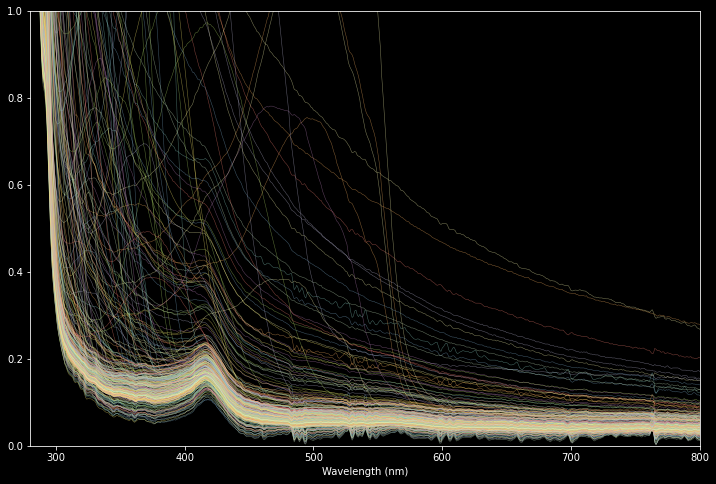

In [2]:
plotTraces(p0.df)

In [3]:
ls platereader/

12032022,161043.CSV*  12032022,172606.CSV*  16032022,135135_220316143740.CSV*
12032022,161911.CSV*  12032022,173428.CSV*  16032022,135135.CSV*
12032022,162732.CSV*  16032022,104721.CSV*  16032022,135950_220316143811.CSV*
12032022,163556.CSV*  16032022,105554.CSV*  16032022,135950.CSV*
12032022,164417.CSV*  16032022,110421.CSV*  16032022,140802_220316143836.CSV*
12032022,165237.CSV*  16032022,130729.CSV*  16032022,140802.CSV*
12032022,170103.CSV*  16032022,131613.CSV*  16032022,141618_220316143856.CSV*
12032022,170926.CSV*  16032022,132435.CSV*  16032022,141618.CSV*
12032022,171744.CSV*  16032022,134319.CSV*


## good/bad 

[`sxiv`](https://github.com/muennich/sxiv) image viewer can open all and output marked images to `stdout`:

``` sxiv -o img/* >> img/good.txt ```

Repeated a few times.

In [4]:
def read(path):
    with open(path) as f:
        return f.read().replace('.png','').splitlines()
    
cats_ = {i.split('.')[0]:read(os.path.join('img', i)) for i in os.listdir('img') if 'txt' in i}
cats = pd.concat([pd.Series(cats_[i], name=i) for i in cats_], axis=1)
cats.head()

,scatter,medium,bad,good,uv-block,ok,perfect,peak
0,S1005,S1005,S1042,S1013,S1005,S1013,S1029,S1005
1,S1021,S1013,S1198,S1029,S1011,S1023,S1047,S1011
2,S1023,S1023,S1208,S1047,S1014,S1026,S1137,S1023
3,S1025,S1025,S1210,S1137,S1021,S1028,S1166,S1025
4,S1028,S1026,S1221,S1156,S1025,S1035,S1168,S1042


In [5]:
overlap = pd.DataFrame([[len(set(cats[i]).intersection(set(cats[j]))) for i in cats] 
                        for j in cats],
                       index = cats.columns,
                       columns = cats.columns)
overlap

,scatter,medium,bad,good,uv-block,ok,perfect,peak
scatter,305,263,97,21,118,243,1,36
medium,263,572,84,226,117,451,25,67
bad,97,84,169,3,116,59,1,76
good,21,226,3,520,21,181,230,6
uv-block,118,117,116,21,224,105,2,75
ok,243,451,59,181,105,503,7,58
perfect,1,25,1,230,2,7,233,1
peak,36,67,76,6,75,58,1,136


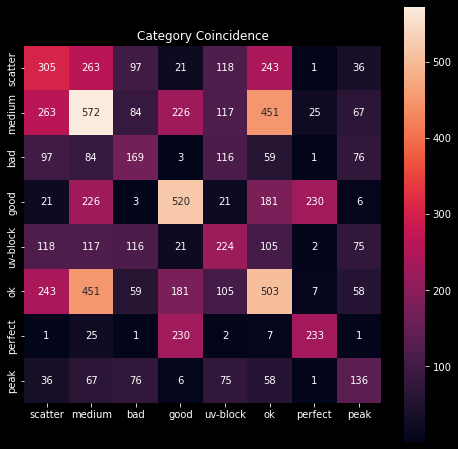

In [6]:
plt.figure(figsize=(8,8))
sns.heatmap(overlap, annot=True, fmt='g', square=True)
plt.title('Category Coincidence')
plt.show()

In [7]:
bad = set(cats['bad'])  | set(cats['scatter']) | set(cats['uv-block'])
medium = set(cats['medium'])  
good = set(cats['good'])  | set(cats['perfect'])
ok = set(good | set(cats['perfect']) | set(cats['ok']))
peak = set(cats['peak'])  
uv_block = set(cats['good'])  
scatter = set(cats['scatter'])  

for i in good.intersection(bad):
    good.discard(i)
for i in medium.intersection(bad):
    medium.discard(i)
for i in ok.intersection(bad):
    ok.discard(i)
for i in ['bad', 'medium', 'scatter','uv-block','peak']:
    for j in good.intersection(set(cats[i])):
        good.discard(j)
for i in [ok, good]:
    for j in bad.intersection(i):
        bad.discard(j)
unclassified = set(re.findall('S[0-9]+', ''.join(os.listdir('img')))).difference(ok | good | bad)

print(f'ok : {len(ok)}')
print(f'good : {len(good)}')
print(f'bad: {len(bad)}')
print(f'medium: {len(medium)}')
print(f'scatter: {len(scatter)}')
print(f'uv_block: {len(uv_block)}')
print(f'peak: {len(peak)}')
print(f'unclassified: {len(unclassified)}')

ok : 543
good : 285
bad: 434
medium: 256
scatter: 305
uv_block: 520
peak: 136
unclassified: 0


## Hack some plotting together

In [18]:
picklist = pd.read_csv('echo/picklists/2022-03-12-00.3-picklist.csv')
wells = {i:picklist.loc[picklist.Cpd == i, :] \
         for i in picklist.Cpd.unique()}
wells

{"['S1005']":    Unnamed: 0        SrcPlate        Cpd SrcWell Destination Plate Name  \
 0           0  src racks 0..4  ['S1005']      A1      dest racks 0..4 0   
 1           1  src racks 0..4  ['S1005']      A1      dest racks 0..4 0   
 2           2  src racks 0..4  ['S1005']      A1      dest racks 0..4 0   
 
   DestWell  Transfer Volume /nl  
 0       A1                 20.0  
 1       A2                605.0  
 2       A3               2000.0  ,
 "['S1199']":    Unnamed: 0        SrcPlate        Cpd SrcWell Destination Plate Name  \
 3           3  src racks 0..4  ['S1199']     A11      dest racks 0..4 0   
 4           4  src racks 0..4  ['S1199']     A11      dest racks 0..4 0   
 5           5  src racks 0..4  ['S1199']     A11      dest racks 0..4 0   
 
   DestWell  Transfer Volume /nl  
 3      G17                 20.0  
 4      G18                605.0  
 5      G19               2000.0  ,
 "['S1212']":    Unnamed: 0        SrcPlate        Cpd SrcWell Destination Plate

In [26]:
data = {i:{'pname':i,
           'x': parse(i)} for i in paths}

In [45]:
from tqdm.notebook import tqdm

def plot_set(wells, title=''):
    assert len(wells) > 0, 'empty set given'
    if len(wells) < 8:
        fig, ax = plt.subplots(len(wells),
                               1,
                               figsize=(6,16))
    else:
        fig, ax = plt.subplots(len(wells)//(nRows:=8),
                               nRows,
                               figsize=(16,128))
    for cpd, ax_ in tqdm(zip(wells,
                             ax.flatten()),
                         total=len(wells)):

        _plate = list(set(wells[cpd]['Destination Plate Name']))[0]
        _wells = wells[cpd]['DestWell'].to_list()
        _vols = wells[cpd]['Transfer Volume /nl'].to_list()
        datas_ = [data[i] for i in filter(lambda item : data[item]['pname'] == _plate, 
                                         data)]
        for data_ in datas_:
            data_cpd = data_['x'].loc[_wells,:]

            x = proc(data_cpd)

            for row_, vol_ in zip(x.index, _vols):
                ax_.plot(x.loc[row_,:], c=plt.cm.cool(vol_/2000))

            ax_.set_xlim(280,800)
            ax_.set_title(cpd)
            ax_.set_xlabel('Wavelength (nm)')
            ax_.axis('off')

    plt.title(title)
    plt.tight_layout()
    plt.show()

  0%|          | 0/978 [00:00<?, ?it/s]

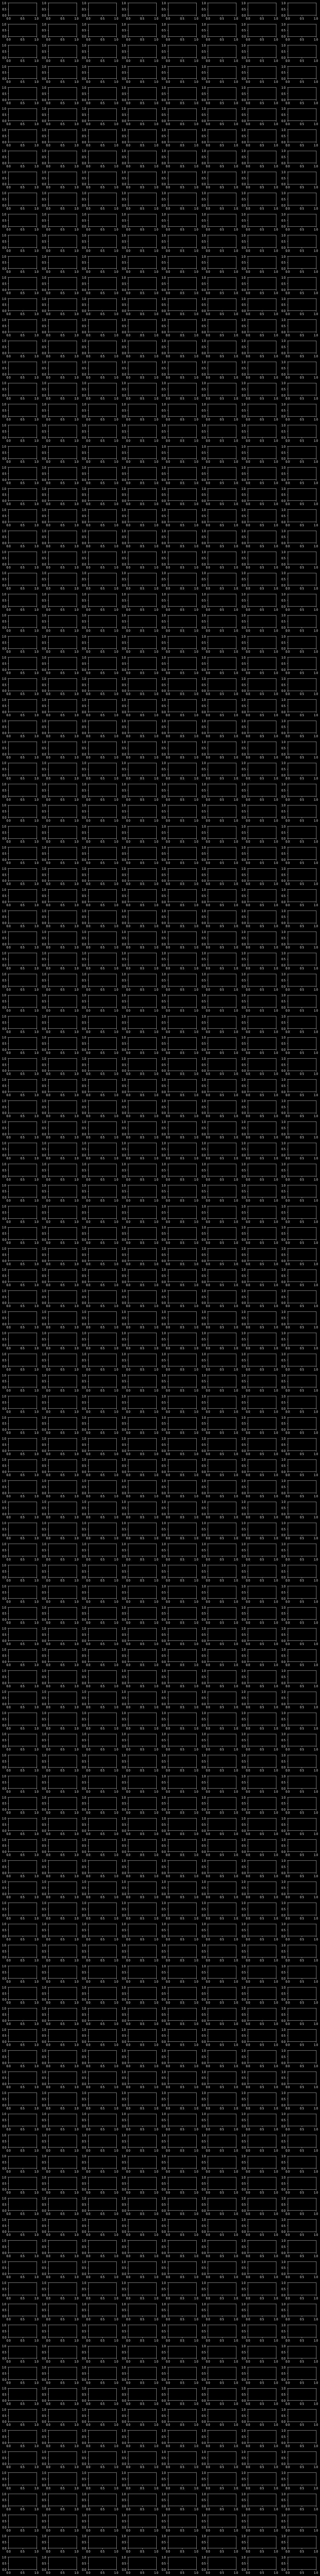

In [46]:
plot_set(wells)

In [ ]:
plot_set(scatter)